# Sponsor Detection

## Purpose
Detection of Sponsor Logo Classes

## Notebook
#### sponsor_data_balance_aug.ipynb
- Data Imbalance Solution
- Data Augmentation


## Methodology
- Pandas, NumPy, Sweetviz (Data Manipulation)
- Pytorch (Data Augmentation, Multiclass Classification, Evaluation)


## Versioning
- Conda (Notebook Versioning Packages)
- Poetry (Script Versioning Package)

## Results:
- Data Formated (YoloV7 Format)
- Data Augment proportionally to Sponsor and Placement
- Data Balance through Data Augment

## Setup

### Path

In [2]:
import sys
from pathlib import Path

project_paths = ['data', 'notebook', 'scripts', 'model', 'src', 'pipeline']

B_PATH = Path.cwd().parents[0]

# Create Project Folders and Set Paths
for _path in project_paths:
    (B_PATH / _path).mkdir(exist_ok=True)
    if not globals().get(f"{_path[:1]}_path".upper()):
        globals()[f"{_path[:1]}_path".upper()] = B_PATH / _path
    else:
        globals()[f"{_path}_path"] = B_PATH / _path

# Custom Paths
RAW_DT_PATH = D_PATH / 'raw'
IMG_DT_PATH = D_PATH / 'images'
ASSETS_PATH = B_PATH / 'assets'

# Script Path
sys.path.append(S_PATH.as_posix())

### Installation

In [24]:
%%bash
pip install bigtree
mamba install -c conda-forge albumentations
mamba install -c conda-forge opencv
mamba install -y pytorch torchvision pytorch-cuda=11.8 -c pytorch -c nvidia


Looking for: ['pytorch', 'torchvision', 'pytorch-cuda=11.8']

pytorch/linux-64                                            Using cache
pytorch/noarch                                              Using cache
nvidia/linux-64                                             Using cache
nvidia/noarch                                               Using cache

Pinned packages:
  - python 3.10.*




warning  libmamba Extracted package cache '/home/leobit/miniconda3/pkgs/blas-1.0-mkl' has invalid size
warning  libmamba Extracted package cache '/home/leobit/miniconda3/pkgs/blas-1.0-mkl' has invalid SHA-256 checksum


Transaction

  Prefix: /home/leobit/miniconda3/envs/cond_sponsor_detection_env

  Updating specs:

   - pytorch
   - torchvision
   - pytorch-cuda=11.8
   - ca-certificates
   - certifi
   - openssl


  Package             Version  Build                         Channel                  Size
────────────────────────────────────────────────────────────────────────────────────────────
  Install:
────────────────────────────────────────────────────────────────────────────────────────────

  + blas                  1.0  mkl                           pkgs/main/linux-64     Cached
  + cuda-cudart       11.8.89  0                             nvidia/linux-64         202kB
  + cuda-cupti        11.8.87  0                             nvidia/linux-64          27MB
  + cuda-libraries     11.8.0  0                             nvidia/linux-64           2kB
  + cuda-nvrtc        11.8.89  0                             nvidia/linux-64          20MB
  + cuda-nvtx         11.8.86  0                       

### Import

In [1]:
import random
import pandas as pd
import torch
import torchvision
import warnings
import numpy as np
import torchvision.transforms.v2 as TR
import shutil
import pickle as pkl
import math
from PIL import Image
from pathlib import PosixPath
from bigtree import list_to_tree, print_tree
from torchvision.io import read_image
from torchvision import datapoints
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import box_convert
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from IPython.display import display


/home/leobit/miniconda3/envs/cond_sponsor_env/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/leobit/miniconda3/envs/cond_sponsor_env/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user fe

### Configuration

In [6]:
# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

# Pandas
pd.set_option('max_colwidth', 999)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

# Future Warning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Pytorch
torchvision.disable_beta_transforms_warning()

# Data Imbalance Check and Set Definition

In [9]:
## Tree structure of IMages
root = list_to_tree([path.as_posix() for path in IMG_DT_PATH.rglob("*")], sep="/")
print_tree(root)

home
└── leobit
    └── Development
        └── software
            └── sponsor-detection
                └── data
                    └── images
                        ├── qatar_airways
                        │   ├── vomitories
                        │   │   ├── 36044-0000444000.JPEG
                        │   │   ├── 25126-0006930000.JPEG
                        │   │   ├── 35333-0007479000.JPEG
                        │   │   ├── 35333-0005238000.JPEG
                        │   │   ├── 25126-0006921000.JPEG
                        │   │   ├── 25126-0006924000.JPEG
                        │   │   ├── 35916-0008286278.JPEG
                        │   │   ├── 35617-0002859000.JPEG
                        │   │   ├── 25126-0006927000.JPEG
                        │   │   └── 35876-0002517000.JPEG
                        │   ├── led_fascia
                        │   │   ├── 25126-0001905000.JPEG
                        │   │   ├── 35731-0006378000.JPEG
                        │   │

In [45]:
df_cv = pd.read_csv(D_PATH / "cv_test_data_v1.csv")

In [ ]:
df_cv.groupby(['sponsor','placement']).count()

width  height  top_left_x  top_left_y  image
sponsor       placement                                                      
barclays      courtside_padding    139     139         139         139    139
              led_fascia            13      13          13          13     13
              scoreboard           109     109         109         109    109
              vomitories            10      10          10          10     10
carmax        led_fascia             6       6           6           6      6
              vomitories             6       6           6           6      6
fanduel       led_fascia             1       1           1           1      1
jetblue       led_fascia            42      42          42          42     42
              scoreboard             1       1           1           1      1
modelo        led_fascia            35      35          35          35     35
              vomitories            16      16          16          16     16
nike          led_fascia             1       1           1           1      1
qatar_airways led_fascia            32      32          32          32     32
              scoreboard             6       6           6           6      6
              vomitories            12      12          12          12     12

In [ ]:
df_cv.sponsor.value_counts(normalize=True)

barclays         0.631702
modelo           0.118881
qatar_airways    0.116550
jetblue          0.100233
carmax           0.027972
fanduel          0.002331
nike             0.002331
Name: sponsor, dtype: float64

In [ ]:
df_cv.placement.value_counts(normalize=True)

courtside_padding    0.324009
led_fascia           0.303030
scoreboard           0.270396
vomitories           0.102564
Name: placement, dtype: float64

In [ ]:
df_cv.groupby(['sponsor', 'placement', 'type_set']).count()

In [ ]:
(D_PATH / 'bak_images').mkdir(parents=True, exist_ok=True)
for path in [path for path in IMG_DT_PATH.glob("*")]:
    if path.is_dir():
        try:
            shutil.copytree(path, (D_PATH / 'bak_images' / path.name))
        except Exception as e:
            print(e)
        shutil.rmtree(path, ignore_errors=True)

In [31]:
df_cv

,sponsor,placement,width,height,top_left_x,top_left_y,image
0,barclays,scoreboard,122,36,482,1,25129-0000414486.JPEG
1,barclays,scoreboard,60,51,411,3,25129-0000414486.JPEG
2,barclays,scoreboard,126,29,477,0,25129-0000417490.JPEG
3,barclays,scoreboard,217,47,515,107,25129-0000464545.JPEG
4,barclays,scoreboard,243,54,502,63,25129-0000467548.JPEG
...,...,...,...,...,...,...,...
424,qatar_airways,scoreboard,381,126,170,0,36959-0007179000.JPEG
425,qatar_airways,led_fascia,129,43,433,274,35904-0003903000.JPEG
426,qatar_airways,led_fascia,111,58,1062,190,35904-0003903000.JPEG
427,qatar_airways,led_fascia,126,32,320,275,35904-0006660000.JPEG


In [49]:
# Creating Train / Validation Sets
sponsor_l = df_cv.sponsor.unique()
placement_l = df_cv.placement.unique()
(IMG_DT_PATH / 'train').mkdir(exist_ok=True)
(IMG_DT_PATH / 'valid').mkdir(exist_ok=True)

df_cv['type_set'] = ''

# Train and Validation with equal Representative Data
for sponsor in sponsor_l:
    for placement in placement_l:
        df_cv_target = df_cv[
            (df_cv.sponsor == sponsor) &
            (df_cv.placement == placement)
        ]
        if df_cv_target.shape[0]:
            df_sample = df_cv_target.sample(frac=0.15)
            idxs = df_sample.index
            for idx in idxs:
                df_cv.at[idx, 'type_set'] = 'VALID'

In [50]:
idxs = df_cv[df_cv.type_set!='VALID'].index
for idx in idxs:
    df_cv.at[idx, 'type_set'] = 'TRAIN'

In [52]:
df_cv.groupby(['sponsor', 'placement', 'type_set']).count()

width  height  top_left_x  \
sponsor       placement         type_set                              
barclays      courtside_padding TRAIN       118     118         118   
                                VALID        21      21          21   
              led_fascia        TRAIN        11      11          11   
                                VALID         2       2           2   
              scoreboard        TRAIN        93      93          93   
                                VALID        16      16          16   
              vomitories        TRAIN         8       8           8   
                                VALID         2       2           2   
carmax        led_fascia        TRAIN         5       5           5   
                                VALID         1       1           1   
              vomitories        TRAIN         5       5           5   
                                VALID         1       1           1   
fanduel       led_fascia        TRAIN         1       1           1   
jetblue       led_fascia        TRAIN        36      36          36   
                                VALID         6       6           6   
              scoreboard        TRAIN         1       1           1   
modelo        led_fascia        TRAIN        30      30          30   
                                VALID         5       5           5   
              vomitories        TRAIN        14      14          14   
                                VALID         2       2           2   
nike          led_fascia        TRAIN         1       1           1   
qatar_airways led_fascia        TRAIN        27      27          27   
                                VALID         5       5           5   
              scoreboard        TRAIN         5       5           5   
                                VALID         1       1           1   
              vomitories        TRAIN        10      10          10   
                                VALID         2       2           2   

                                          top_left_y  image  
sponsor       placement         type_set                     
barclays      courtside_padding TRAIN            118    118  
                                VALID             21     21  
              led_fascia        TRAIN             11     11  
                                VALID              2      2  
              scoreboard        TRAIN             93     93  
                                VALID             16     16  
              vomitories        TRAIN              8      8  
                                VALID              2      2  
carmax        led_fascia        TRAIN              5      5  
                                VALID              1      1  
              vomitories        TRAIN              5      5  
                                VALID              1      1  
fanduel       led_fascia        TRAIN              1      1  
jetblue       led_fascia        TRAIN             36     36  
                                VALID              6      6  
              scoreboard        TRAIN              1      1  
modelo        led_fascia        TRAIN             30     30  
                                VALID              5      5  
              vomitories        TRAIN             14     14  
                                VALID              2      2  
nike          led_fascia        TRAIN              1      1  
qatar_airways led_fascia        TRAIN             27     27  
                                VALID              5      5  
              scoreboard        TRAIN              5      5  
                                VALID              1      1  
              vomitories        TRAIN             10     10  
                                VALID              2      2

In [54]:
train_df = df_cv[df_cv.type_set=='TRAIN']
val_df = df_cv[df_cv.type_set=='VALID']

# Data Augmentation

In [10]:
help(TR.Compose)

Help on class Compose in module torchvision.transforms.v2._container:

class Compose(torchvision.transforms.v2._transform.Transform)
 |  Compose(transforms: Sequence[Callable]) -> None
 |  
 |  [BETA] Composes several transforms together.
 |  
 |  .. v2betastatus:: Compose transform
 |  
 |  This transform does not support torchscript.
 |  Please, see the note below.
 |  
 |  Args:
 |      transforms (list of ``Transform`` objects): list of transforms to compose.
 |  
 |  Example:
 |      >>> transforms.Compose([
 |      >>>     transforms.CenterCrop(10),
 |      >>>     transforms.PILToTensor(),
 |      >>>     transforms.ConvertImageDtype(torch.float),
 |      >>> ])
 |  
 |  .. note::
 |      In order to script the transformations, please use ``torch.nn.Sequential`` as below.
 |  
 |      >>> transforms = torch.nn.Sequential(
 |      >>>     transforms.CenterCrop(10),
 |      >>>     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
 |      >>> )
 |      >>> script

In [69]:
BBOX_COLS = ['top_left_x', 'top_left_y', 'width', 'height']
img_tmp = random.choice(list(IMG_DT_PATH.rglob("*.JPEG")))
bbox_tmp_arr = df_cv[df_cv.image == img_tmp.name][BBOX_COLS].to_numpy()
label_tmp_arr = np.arange(bbox_tmp_arr.shape[0])

In [70]:
# Torch format
img_torch = datapoints.Image(read_image(img_tmp.as_posix()))
bbox_torch = datapoints.BoundingBox(
    data=bbox_tmp_arr,
    format=datapoints.BoundingBoxFormat.XYWH,
    spatial_size=img_torch.shape[-2:]
)
label_torch = torch.as_tensor(label_tmp_arr, dtype=torch.uint8)

In [105]:
# Transforms for Augment
transform = TR.RandomChoice(
    [
        TR.RandomHorizontalFlip(),
        TR.RandomCrop((640, 640), pad_if_needed=True),
        TR.RandomRotation(60),
        TR.ColorJitter(),
    ], p=[3, 2, 4, 7]
)

In [71]:
bbox_torch_conv = box_convert(
    bbox_torch,
    'xywh',
    'xyxy'
)

In [172]:
TR.ToPILImage()(img_torch).save('img_tmp.jpg')

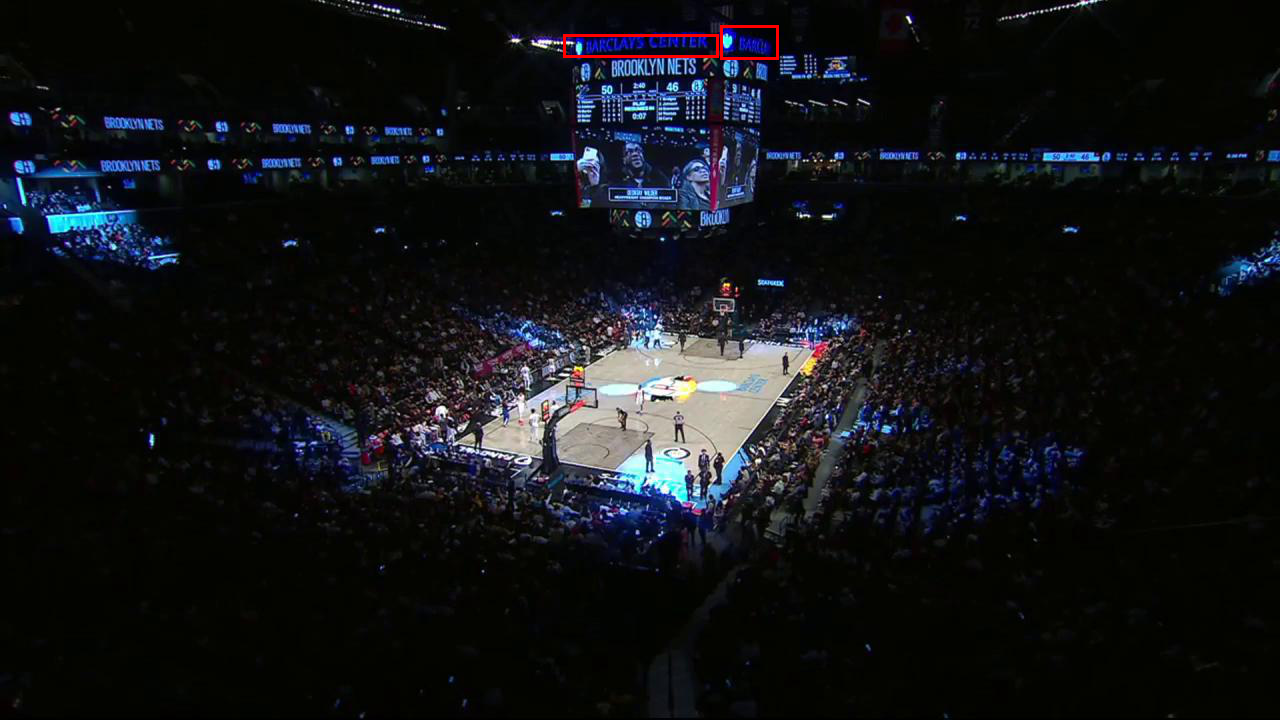

In [14]:
annotated_image = draw_bounding_boxes(img_torch, bbox_torch_conv, colors="Red", width=3)
TR.ToPILImage()(annotated_image)

In [100]:
# Augment Test
new_image, new_bounding_boxes, new_labels = transform(img_torch, bbox_torch, label_torch)
new_bounding_boxes = box_convert(
    new_bounding_boxes,
    'xywh',
    'xyxy'
)

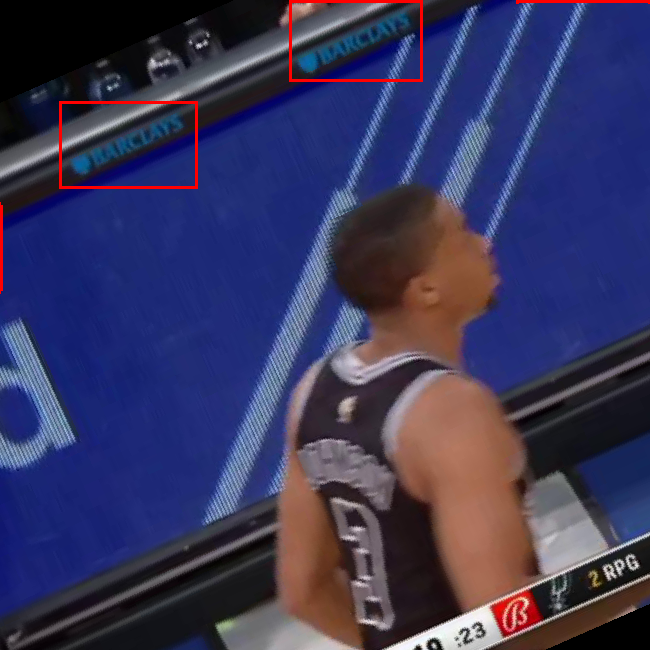

In [283]:
annotated_image = draw_bounding_boxes(new_image, new_bounding_boxes, colors="Red", width=3)
TR.ToPILImage()(annotated_image)

In [108]:
train_df.groupby(['sponsor', 'placement']).count()

width  height  top_left_x  top_left_y  image  \
sponsor       placement                                                         
barclays      courtside_padding    118     118         118         118    118   
              led_fascia            11      11          11          11     11   
              scoreboard            93      93          93          93     93   
              vomitories             8       8           8           8      8   
carmax        led_fascia             5       5           5           5      5   
              vomitories             5       5           5           5      5   
fanduel       led_fascia             1       1           1           1      1   
jetblue       led_fascia            36      36          36          36     36   
              scoreboard             1       1           1           1      1   
modelo        led_fascia            30      30          30          30     30   
              vomitories            14      14          14          14     14   
nike          led_fascia             1       1           1           1      1   
qatar_airways led_fascia            27      27          27          27     27   
              scoreboard             5       5           5           5      5   
              vomitories            10      10          10          10     10   

                                 type_set  
sponsor       placement                    
barclays      courtside_padding       118  
              led_fascia               11  
              scoreboard               93  
              vomitories                8  
carmax        led_fascia                5  
              vomitories                5  
fanduel       led_fascia                1  
jetblue       led_fascia               36  
              scoreboard                1  
modelo        led_fascia               30  
              vomitories               14  
nike          led_fascia                1  
qatar_airways led_fascia               27  
              scoreboard                5  
              vomitories               10

In [138]:
train_df = train_df[['sponsor', 'placement', 'top_left_x', 'top_left_y','width', 'height', 'image', 'type_set']]
val_df = val_df[['sponsor', 'placement', 'top_left_x', 'top_left_y','width', 'height', 'image', 'type_set']]

In [184]:
## Augment Training Dataset
transform = TR.RandomChoice(
    [
        TR.RandomHorizontalFlip(),
        TR.RandomCrop((640, 640), pad_if_needed=True),
        TR.RandomRotation(60),
        TR.ColorJitter(),
    ], p=[3, 2, 4, 7]
)

def augment_image(img_path: PosixPath, n_images: int) -> list | list:
    """Return Augmented Images
    Args:
        img_path (Path): POSIX Path of the image
        n_images (n_images): Target Number of Ouput Images
    Returns:
        new_images (list): List with new images
        new_bboxs (list): Bonding Boxes from Augmented Images
    """
    BBOX_COLS = ['top_left_x', 'top_left_y', 'width', 'height']
    bbox_tmp_arr = train_df[train_df.image == img_path.name][BBOX_COLS].to_numpy()
    label_tmp_arr = np.arange(bbox_tmp_arr.shape[0])

    img_torch = datapoints.Image(read_image(img_path.as_posix()))
    bbox_torch = datapoints.BoundingBox(
        data=bbox_tmp_arr,
        format=datapoints.BoundingBoxFormat.XYWH,
        spatial_size=img_torch.shape[-2:]
    )
    label_torch = torch.as_tensor(label_tmp_arr, dtype=torch.uint8)
    new_images = []
    new_bboxs = []
    for _i in range(n_images):
        new_image, new_bounding_boxes, _ = transform(
            img_torch,
            bbox_torch,
            label_torch
        )
        new_images.append(new_image)
        new_bboxs.append(new_bounding_boxes)
    return new_images, new_bboxs

# Target to augment some classes
AUGMENT_TARGET = 120

sponsor_l = train_df.sponsor.unique()
df_augment = pd.DataFrame({col:[] for col in train_df.columns.tolist()})

# Augment Dataset by Sponsor and Placement Representative Data
for sponsor in sponsor_l:
    if sponsor == 'barclays':
        continue
    df_sponsor = train_df[train_df.sponsor == sponsor]
    mult_factor = AUGMENT_TARGET / df_sponsor.shape[0]
    placement_l = df_sponsor.placement.unique()
    for placement in placement_l:
        df_plac = df_sponsor[df_sponsor.placement == placement]
        qtd_images_aug = round(df_plac.shape[0] * mult_factor) - df_plac.shape[0]
        unique_images = df_plac.image.unique()
        n_images = len(unique_images)
        aug_per_image = math.floor(qtd_images_aug / n_images)
        rest_image = qtd_images_aug % n_images
        image_idx = 0
        # Calculate each number of Augmented Images for each placement proportionally
        for image in unique_images:
            if qtd_images_aug < aug_per_image:
                new_images, new_bboxs = augment_image(
                    IMG_DT_PATH / image,
                    n_images=rest_image
                )
                for new_image, new_bbox_l in zip(new_images, new_bboxs):
                    new_image_name = f"{image.split('.')[0]}_{(image_idx:=image_idx+1)}.JPEG"
                    TR.ToPILImage()(new_image).save(
                        IMG_DT_PATH / 'augmented_train' / new_image_name
                        )
                    target_bbox = random.choice(np.array(new_bbox_l)).tolist()
                    target_row = [sponsor, placement] + target_bbox + [new_image_name, 'TRAIN']
                    df_augment.loc[len(df_augment)+1, :] = target_row
            else:
                new_images, new_bboxs = augment_image(
                    IMG_DT_PATH / image,
                    n_images=aug_per_image
                )
                for new_image, new_bbox_l in zip(new_images, new_bboxs):
                    new_image_name = f"{image.split('.')[0]}_{(image_idx:=image_idx+1)}.JPEG"
                    TR.ToPILImage()(new_image).save(
                        IMG_DT_PATH / 'augmented_train' / new_image_name
                        )
                    target_bbox = random.choice(np.array(new_bbox_l)).tolist()
                    target_row = [sponsor, placement] + target_bbox + [new_image_name, 'TRAIN']
                    df_augment.loc[len(df_augment)+1, :] = target_row
            qtd_images_aug -= aug_per_image

In [ ]:
df_augment.groupby(['sponsor', 'placement']).count()

In [ ]:
for image in df_augment.image.tolist():
    BBOX_COLS = ['top_left_x', 'top_left_y', 'width', 'height']
    bbox_tmp_arr = df_augment[df_augment.image == image][BBOX_COLS].to_numpy()
    label_tmp_arr = np.arange(bbox_tmp_arr.shape[0])
    img_torch = datapoints.Image(read_image((IMG_DT_PATH / 'augmented_train' / image).as_posix()))
    bbox_torch = datapoints.BoundingBox(
        data=bbox_tmp_arr,
        format=datapoints.BoundingBoxFormat.XYWH,
        spatial_size=img_torch.shape[-2:]
    )
    label_torch = torch.as_tensor(label_tmp_arr, dtype=torch.uint8)
    bbox_torch_conv = box_convert(
        bbox_torch,
        'xywh',
        'xyxy'
    )
    annotated_image = draw_bounding_boxes(img_torch, bbox_torch_conv, colors="Red", width=3)
    display(TR.ToPILImage()(annotated_image))

In [161]:
train_df.groupby(['sponsor', 'placement']).count()

top_left_x  top_left_y  width  height  image  \
sponsor       placement                                                         
barclays      courtside_padding         118         118    118     118    118   
              led_fascia                 11          11     11      11     11   
              scoreboard                 93          93     93      93     93   
              vomitories                  8           8      8       8      8   
carmax        led_fascia                  5           5      5       5      5   
              vomitories                  5           5      5       5      5   
fanduel       led_fascia                  1           1      1       1      1   
jetblue       led_fascia                 36          36     36      36     36   
              scoreboard                  1           1      1       1      1   
modelo        led_fascia                 30          30     30      30     30   
              vomitories                 14          14     14      14     14   
nike          led_fascia                  1           1      1       1      1   
qatar_airways led_fascia                 27          27     27      27     27   
              scoreboard                  5           5      5       5      5   
              vomitories                 10          10     10      10     10   

                                 type_set  
sponsor       placement                    
barclays      courtside_padding       118  
              led_fascia               11  
              scoreboard               93  
              vomitories                8  
carmax        led_fascia                5  
              vomitories                5  
fanduel       led_fascia                1  
jetblue       led_fascia               36  
              scoreboard                1  
modelo        led_fascia               30  
              vomitories               14  
nike          led_fascia                1  
qatar_airways led_fascia               27  
              scoreboard                5  
              vomitories               10

In [ ]:
train_df_aug = pd.concat([train_df, df_augment])

In [206]:
# Format for YoloV7
sponsor_l = train_df.sponsor.unique().tolist()
train_df_aug['xmin'] = train_df_aug['top_left_x'].astype(int)
train_df_aug['ymin'] = train_df_aug['top_left_y'].astype(int)
train_df_aug['xmax'] = train_df_aug['top_left_x'].astype(int) + train_df_aug['width'].astype(int)
train_df_aug['ymax'] = train_df_aug['top_left_y'].astype(int) + train_df_aug['height'].astype(int)
train_df_aug['class_name'] = train_df_aug['sponsor']
train_df_aug['has_annotation'] = True
train_df_aug['image_id'] = list(range(len(train_df_aug)))
train_df_aug['class_id'] = train_df_aug.sponsor.apply(lambda x: sponsor_l.index(x))

In [244]:
train_df_aug.tail(60)

,sponsor,placement,top_left_x,top_left_y,width,height,image,type_set,xmin,ymin,xmax,ymax,class_name,has_annotation,image_id,class_id
492,nike,led_fascia,80.0,96.0,133.0,47.0,35914-0001158000_118.JPEG,TRAIN,80,96,213,143,nike,True,856,5
493,nike,led_fascia,80.0,96.0,133.0,47.0,35914-0001158000_119.JPEG,TRAIN,80,96,213,143,nike,True,857,5
494,qatar_airways,led_fascia,909.0,0.0,113.0,0.0,25126-0001905000_1.JPEG,TRAIN,909,0,1022,0,qatar_airways,True,858,6
495,qatar_airways,led_fascia,1259.0,292.0,20.0,86.0,25126-0001905000_2.JPEG,TRAIN,1259,292,1279,378,qatar_airways,True,859,6
496,qatar_airways,led_fascia,33.0,201.0,40.0,23.0,35617-0001206000_3.JPEG,TRAIN,33,201,73,224,qatar_airways,True,860,6
497,qatar_airways,led_fascia,640.0,237.0,0.0,18.0,35617-0001206000_4.JPEG,TRAIN,640,237,640,255,qatar_airways,True,861,6
498,qatar_airways,led_fascia,99.0,3.0,473.0,49.0,35914-0003024000_5.JPEG,TRAIN,99,3,572,52,qatar_airways,True,862,6
499,qatar_airways,led_fascia,99.0,3.0,473.0,49.0,35914-0003024000_6.JPEG,TRAIN,99,3,572,52,qatar_airways,True,863,6
500,qatar_airways,led_fascia,154.0,184.0,820.0,52.0,35846-0003120000_7.JPEG,TRAIN,154,184,974,236,qatar_airways,True,864,6
501,qatar_airways,led_fascia,154.0,184.0,820.0,52.0,35846-0003120000_8.JPEG,TRAIN,154,184,974,236,qatar_airways,True,865,6


In [241]:
train_df_aug.groupby(['class_name', 'class_id']).count()

,,sponsor,placement,top_left_x,top_left_y,width,height,image,type_set,xmin,ymin,xmax,ymax,has_annotation,image_id
class_name,class_id,,,,,,,,,,,,,,
barclays,0,230,230,230,230,230,230,230,230,230,230,230,230,230,230
carmax,1,117,117,117,117,117,117,117,117,117,117,117,117,117,117
fanduel,2,120,120,120,120,120,120,120,120,120,120,120,120,120,120
jetblue,3,115,115,115,115,115,115,115,115,115,115,115,115,115,115
modelo,4,114,114,114,114,114,114,114,114,114,114,114,114,114,114
nike,5,120,120,120,120,120,120,120,120,120,120,120,120,120,120
qatar_airways,6,100,100,100,100,100,100,100,100,100,100,100,100,100,100


In [242]:
# Format for YoloV7
sponsor_l = train_df.sponsor.unique().tolist()
val_df['xmin'] = val_df['top_left_x'].astype(int)
val_df['ymin'] = val_df['top_left_y'].astype(int)
val_df['xmax'] = val_df['top_left_x'].astype(int) + val_df['width'].astype(int)
val_df['ymax'] = val_df['top_left_y'].astype(int) + val_df['height'].astype(int)
val_df['class_name'] = val_df['sponsor']
val_df['has_annotation'] = True
val_df['image_id'] = list(range(len(train_df_aug), len(train_df_aug) + len(val_df)))
val_df['class_id'] = val_df.sponsor.apply(lambda x: sponsor_l.index(x))

/tmp/ipykernel_16943/1116298740.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['xmin'] = val_df['top_left_x'].astype(int)
/tmp/ipykernel_16943/1116298740.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['ymin'] = val_df['top_left_y'].astype(int)
/tmp/ipykernel_16943/1116298740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [245]:
train_df_aug.shape

(916, 16)

In [223]:
df_cv = pd.concat([df_cv, df_augment])

In [237]:
df_cv.drop(['type_set'], axis=1, inplace=True)

In [246]:
with open(D_PATH / 'dataset' / 'train_df.pkl', 'wb') as f:
    pkl.dump(train_df_aug, f)
with open(D_PATH / 'dataset' / 'val_df.pkl', 'wb') as f:
    pkl.dump(val_df, f)

In [239]:
df_cv.to_csv(D_PATH / 'cv_test_data_v2.csv', index=False)